In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import copy

In [2]:
# Read data 
real_data = np.loadtxt('real_observations.csv', delimiter=',')
description = np.loadtxt('observation_description.csv', delimiter=',',dtype='object')
param_values = 1/np.loadtxt('param_values.csv', delimiter=',')
func_eval = np.loadtxt('func_eval.csv', delimiter=',')
param_values_test = 1/np.loadtxt('param_values_test.csv', delimiter=',')
func_eval_test = np.loadtxt('func_eval_test.csv', delimiter=',')

In [3]:
print('N:', func_eval.shape[0])
print('D:', param_values.shape[1])
print('M:', real_data.shape[0])
print('P:', description.shape[1])

N: 2000
D: 10
M: 492
P: 2


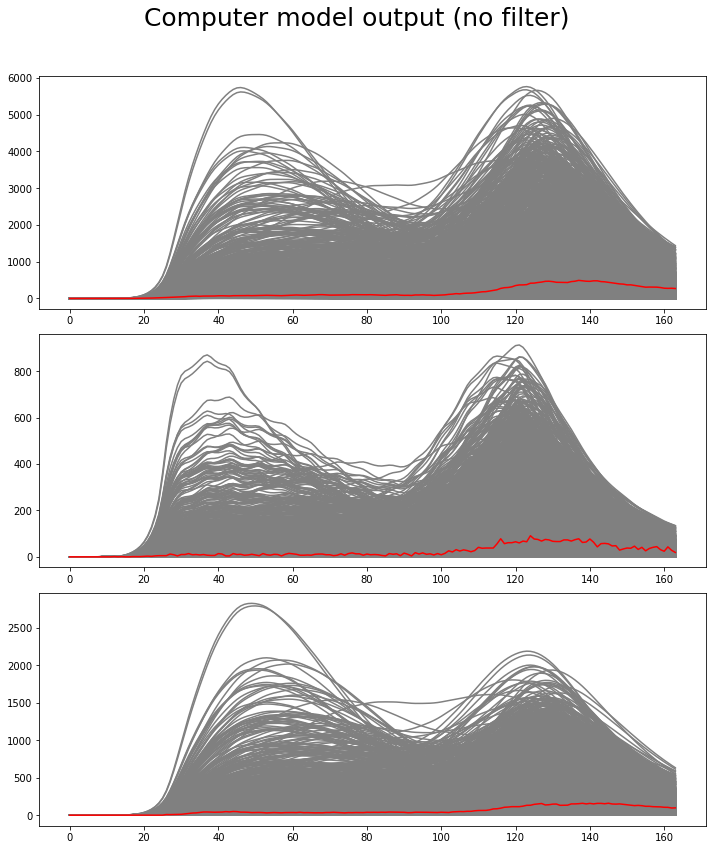

In [4]:
def plot_observed_data(description, func_eval, real_data, param_values, title = None):
    '''
    Plots a list of profiles in the same figure. Each profile corresponds
    to a stochastic replica for the given instance.
    '''
    plt.rcParams["font.size"] = "10"
    N = len(param_values)
    D = description.shape[1]
    T = len(np.unique(description[:,0]))
    type_no = len(np.unique(description[:,1]))
    fig, axs = plt.subplots(type_no, figsize=(10, 12))
    if title is not None:
        fig.suptitle(title, fontsize=25)
    for j in range(type_no):
        for i in range(N):
            axs[j].plot(range(T), func_eval[i,(j*T):(j*T + T)], color='grey')
        axs[j].plot(range(T), real_data[(j*T):(j*T + T)], color='red')
    fig.tight_layout()
    fig.subplots_adjust(top=0.9) 
    plt.show()
plot_observed_data(description, func_eval, real_data, param_values, title='Computer model output (no filter)')

## Fit an emulator using unfiltered data

In [5]:
current = os.path.abspath(os.getcwd())
sys.path.append(os.path.normpath(os.path.join(os.path.dirname(current), '..')))
from base.emulation import emulator

In [6]:
x = np.reshape(np.tile(range(164), 3), (492, 1))

### Method 1

In [7]:
emulator_nofilter = emulator(x, param_values, func_eval.T, method = 'PCGP_ozge', args = {'is_pca': True}) 
pred_model_nofilter = emulator_nofilter.predict(x, param_values)
pred_mean = pred_model_nofilter.mean()

Function supplementtheta not found in module!
no of pcs: 7


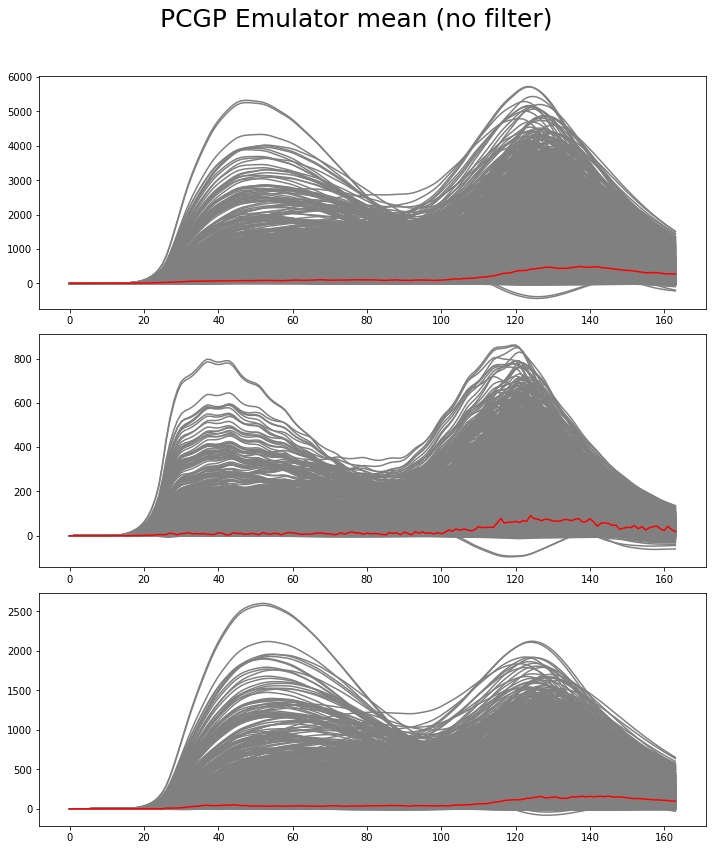

In [9]:
plot_observed_data(description, pred_mean, real_data, param_values, title='PCGP Emulator mean (no filter)')

### Method 2

In [10]:
emulator_nofilter_2 = emulator(x, param_values, func_eval.T, method = 'PCGPwM') 
pred_model_nofilter_2 = emulator_nofilter_2.predict(x, param_values)
pred_mean_2 = pred_model_nofilter_2.mean()

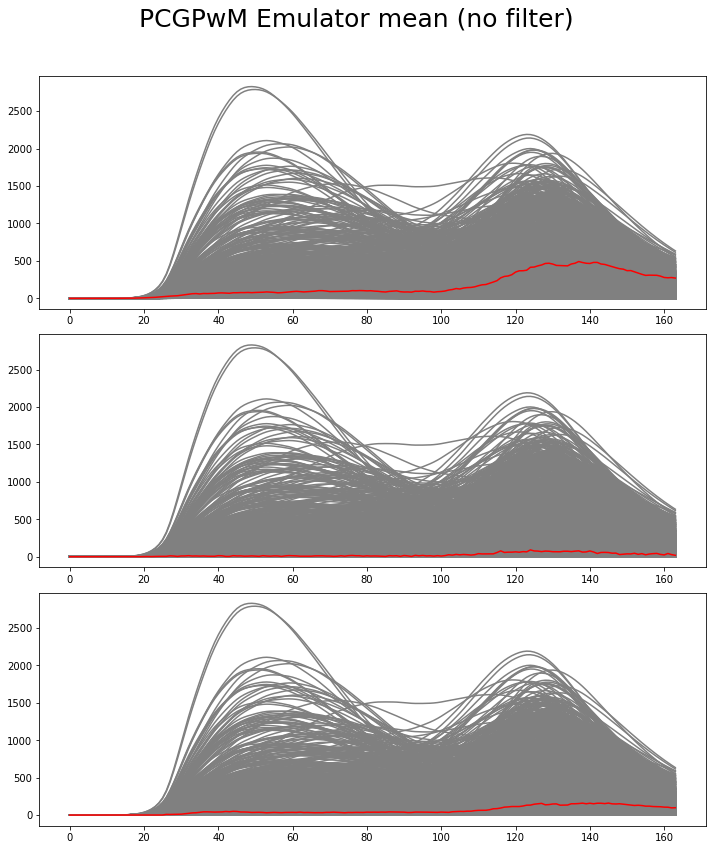

In [11]:
plot_observed_data(description, pred_mean_2.T, real_data, param_values, title='PCGPwM Emulator mean (no filter)')

## Fit an emulator using filtered data

### Filter out the data

In [12]:
par_out = param_values[np.logical_or.reduce((func_eval[:, 130] <= 200, func_eval[:, 50] >= 1000, func_eval[:, 130] >= 1000)),:]
par_in = param_values[np.logical_and.reduce((func_eval[:, 130] > 200, func_eval[:, 50] < 1000, func_eval[:, 130] < 1000)), :]
func_eval_in = func_eval[np.logical_and.reduce((func_eval[:, 130] > 200, func_eval[:, 50] < 1000, func_eval[:, 130] < 1000)), :]

### Method 1 (filtered)

Function supplementtheta not found in module!
no of pcs: 5


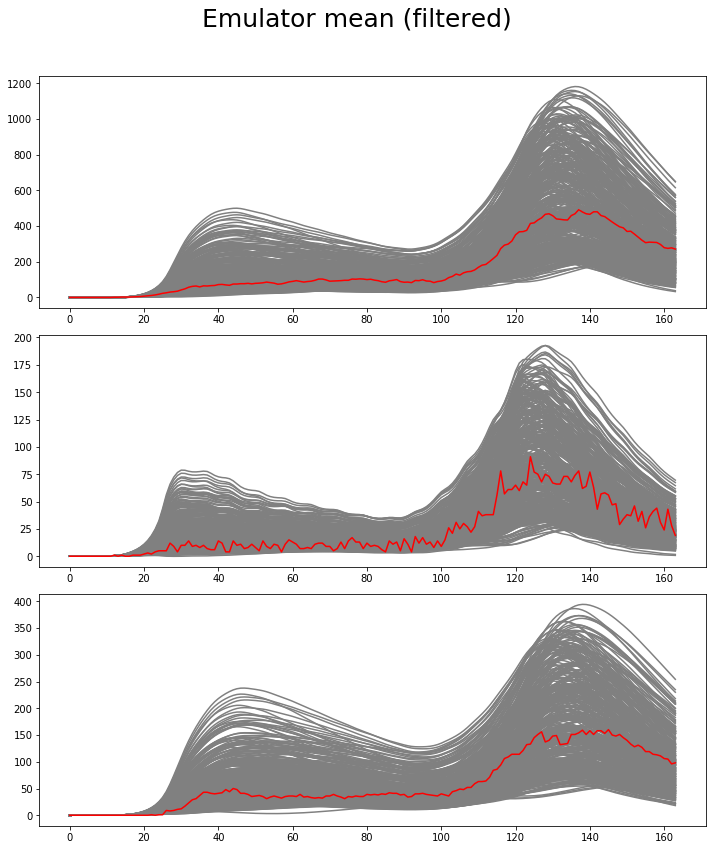

In [13]:
emulator_filter = emulator(x, par_in, func_eval_in.T, method = 'PCGP_ozge', args = {'is_pca': True}) 
pred_model_filter = emulator_nofilter.predict(x, par_in)
pred_mean_f = pred_model_filter.mean()
plot_observed_data(description, pred_mean_f, real_data, par_in, title='Emulator mean (filtered)')

### Method 2 (filtered)

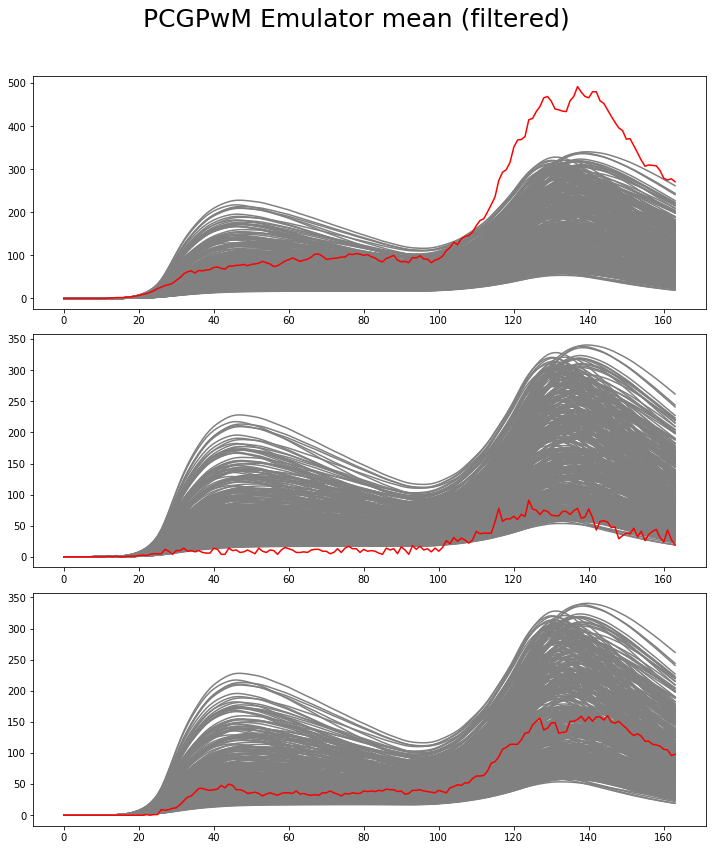

In [14]:
emulator_filter_2 = emulator(x, par_in, func_eval_in.T, method = 'PCGPwM') 
pred_model_filter_2 = emulator_filter_2.predict(x, par_in)
pred_mean_f_2 = pred_model_filter_2.mean()
plot_observed_data(description, pred_mean_f_2.T, real_data, par_in, title='PCGPwM Emulator mean (filtered)')

## Fit a classification model to predict filtered results

In [36]:
y = np.zeros(len(pred_mean))
y[np.logical_and.reduce((pred_mean[:, 130] > 200, pred_mean[:, 50] < 1000, pred_mean[:, 130] < 1000))] = 1
 
# Create the test data
pred_model_nofilter_test = emulator_nofilter.predict(x, param_values_test)
pred_mean_test = pred_model_nofilter_test.mean()
y_test = np.zeros(len(pred_mean_test))
y_test[np.logical_and.reduce((pred_mean_test[:, 130] > 200, pred_mean_test[:, 50] < 1000, pred_mean_test[:, 130] < 1000))] = 1

# Create a balanced data set
X_0 = pred_mean[y == 0][0:450]
y_0 = y[y == 0][0:450]
X_1 = pred_mean[y == 1]
y_1 = y[y == 1]
    
X = np.concatenate((X_0, X_1), axis=0)
y = np.concatenate((y_0, y_1), axis=0)

# Fit the classification model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = RandomForestClassifier(n_estimators = 100, random_state = 42)
model.fit(X, y)

#Training accuracy
print(model.score(X, y))
print(confusion_matrix(y, model.predict(X)))

#Test accuracy
print(model.score(pred_mean_test, y_test))
print(confusion_matrix(y_test, model.predict(pred_mean_test)))

1.0
[[450   0]
 [  0 413]]
0.99
[[1532   16]
 [   4  448]]


## Compare the calibrators